## Step 1: Imports and Raw Data Loading
Load necessary libraries and the raw AnnData object containing the UMI counts matrix for the pan-cancer dataset.


In [1]:
# 📚 Imports
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation

# 📥 Load raw AnnData object
adata = sc.read("../../data/pancancer_raw_umi.h5ad")
print(f"✅ Loaded AnnData object: {adata.shape}")


✅ Loaded AnnData object: (56982, 30314)


## Step 2: Calculate Per-Cell QC Metrics
Convert the expression matrix to a dense format and calculate key QC metrics: total counts and number of expressed genes per cell.


In [2]:
# 📊 Plot settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# 🧬 Convert to dense DataFrame
expr_df = adata.to_df()

# 📏 Calculate QC metrics
qc_df = pd.DataFrame(index=expr_df.index)
qc_df["total_counts"] = expr_df.sum(axis=1)
qc_df["n_genes"] = (expr_df > 0).sum(axis=1)
qc_df["log_total_counts"] = np.log1p(qc_df["total_counts"])
qc_df["log_n_genes"] = np.log1p(qc_df["n_genes"])

print(f"✅ Expression matrix shape: {expr_df.shape}")
qc_df.describe()


✅ Expression matrix shape: (56982, 30314)


,total_counts,n_genes,log_total_counts,log_n_genes
count,56982.000000,56982.000000,56982.000000,56982.000000
mean,18944.774051,3653.265540,9.667465,8.152494
std,12199.807005,1144.470853,0.604966,0.326175
min,3648.000000,919.000000,8.202208,6.824374
25%,10155.000000,2770.250000,9.225820,7.927054
50%,16026.000000,3580.000000,9.682030,8.183397
75%,24164.000000,4411.000000,10.092661,8.392083
max,126433.000000,9292.000000,11.747476,9.137017


## Step 3: Define QC Thresholds
Use median absolute deviation (MAD) to define thresholds for filtering out low-quality cells with unusually high or low counts or gene numbers.


In [3]:
# 🧾 Log MAD-based thresholds
def log_mad_thresholds(series, n_mads=5, label=""):
    med = np.median(series)
    mad = median_abs_deviation(series)
    low = med - n_mads * mad
    high = med + n_mads * mad
    print(f"📏 {label}: median={med:.2f}, MAD={mad:.2f}, low={low:.2f}, high={high:.2f}")

log_mad_thresholds(qc_df["log_total_counts"], 5, "log_total_counts")
log_mad_thresholds(qc_df["log_n_genes"], 5, "log_n_genes")


📏 log_total_counts: median=9.68, MAD=0.43, low=7.52, high=11.85
📏 log_n_genes: median=8.18, MAD=0.23, low=7.04, high=9.33


## Step 4: Visualize QC Distributions
Plot histograms and scatter plots to understand the distribution of QC metrics across cells.


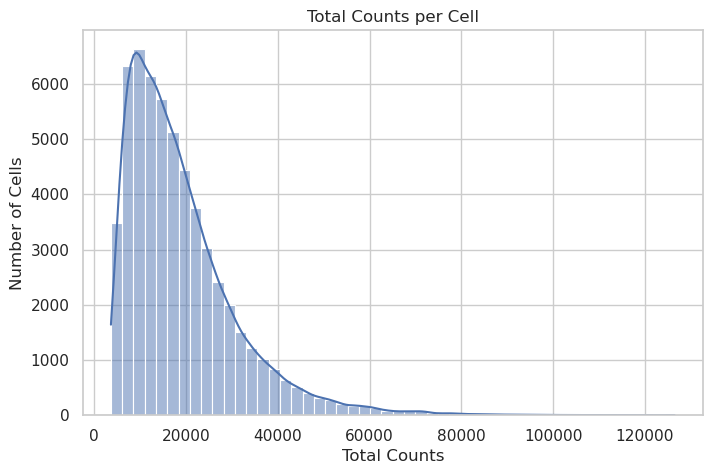

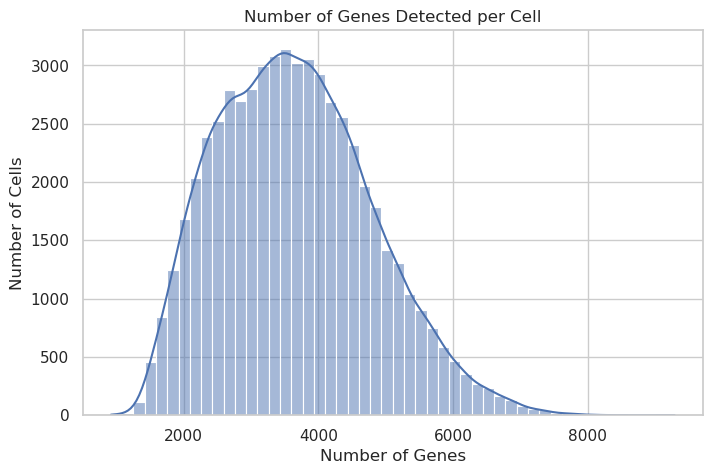

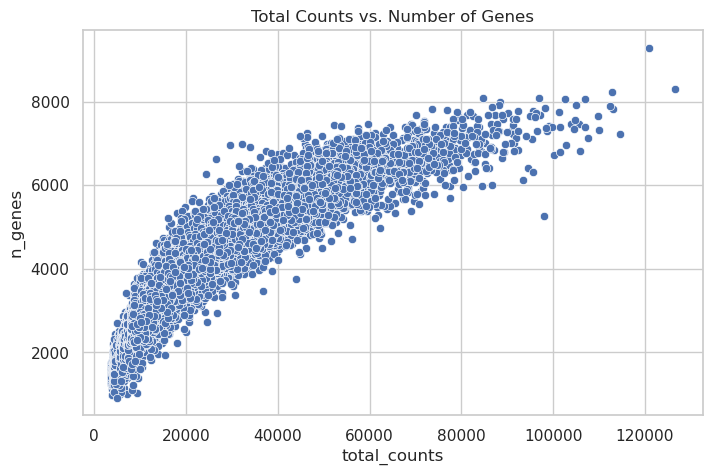

In [4]:
# 📊 Visual inspection
sns.histplot(qc_df["total_counts"], bins=50, kde=True)
plt.title("Total Counts per Cell")
plt.xlabel("Total Counts")
plt.ylabel("Number of Cells")
plt.show()

sns.histplot(qc_df["n_genes"], bins=50, kde=True)
plt.title("Number of Genes Detected per Cell")
plt.xlabel("Number of Genes")
plt.ylabel("Number of Cells")
plt.show()

sns.scatterplot(data=qc_df, x="total_counts", y="n_genes")
plt.title("Total Counts vs. Number of Genes")
plt.show()


## Step 5: Identify and Remove Outliers
Use MAD thresholds to flag and remove outlier cells with unusual QC metrics. This helps ensure only high-quality cells are retained.


In [5]:
# 🚨 Outlier detection
def is_outlier(series, n_mads=5):
    med = np.median(series)
    mad = median_abs_deviation(series)
    return (series < med - n_mads * mad) | (series > med + n_mads * mad)

qc_df["outlier_counts"] = is_outlier(qc_df["log_total_counts"])
qc_df["outlier_genes"] = is_outlier(qc_df["log_n_genes"])
qc_df["is_outlier"] = qc_df[["outlier_counts", "outlier_genes"]].any(axis=1)

print(f"⚠️ Number of cells flagged as outliers: {qc_df['is_outlier'].sum()}")

# 🧹 Filter outliers
filtered_adata = adata[~qc_df["is_outlier"]].copy()
print(f"✅ Filtered AnnData object: {filtered_adata.shape}")


⚠️ Number of cells flagged as outliers: 12
✅ Filtered AnnData object: (56970, 30314)


## Step 6: Save the Clean Dataset
Export the filtered high-quality single-cell data for downstream analysis.


In [6]:
# 💾 Save filtered dataset
filtered_adata.write("../../data/pancancer_qc_filtered.h5ad")
print("📁 Saved QC-filtered dataset to 'pancancer_qc_filtered.h5ad'")


📁 Saved QC-filtered dataset to 'pancancer_qc_filtered.h5ad'
